# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: CNN GAN with FMNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_1112/957460449.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

# Import the data

In [3]:
# transformations
transform = T.Compose([ 
                        T.Resize(64),
                        T.ToTensor(),
                        T.Normalize((.5,),(.5,)),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [4]:
# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
classes2keep = [ 'Trouser','Sneaker','Pullover' ]
# classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ]



# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
  classidx = dataset.classes.index(classes2keep[i])
  images2use = torch.cat( (images2use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


/Users/antonis/miniforge3/envs/dfl_test/lib/python3.8/site-packages/torchvision/transforms/functional.py:79: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


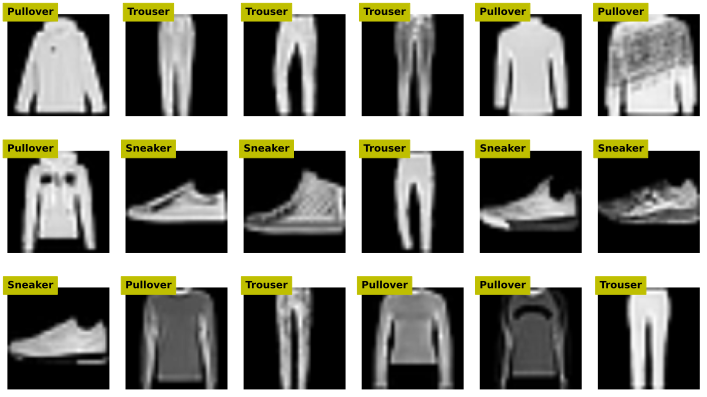

In [5]:
# view some images
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [6]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [7]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


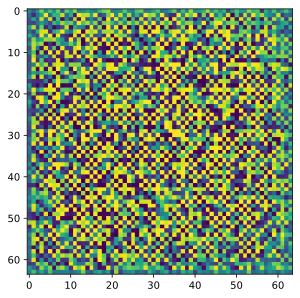

In [8]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

# Train the models!

In [9]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [10]:
# number of epochs (expressed in number of batches)
num_epochs = int(2500/len(data_loader))

losses  = []
disDecs = []

for epochi in range(num_epochs):

  for data,_ in data_loader:
    
    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])
    
    d1 = torch.mean((pred_real>.5).float()).detach()
    d2 = torch.mean((pred_fake>.5).float()).detach()
    disDecs.append([d1,d2])


  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 13/13

In [11]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

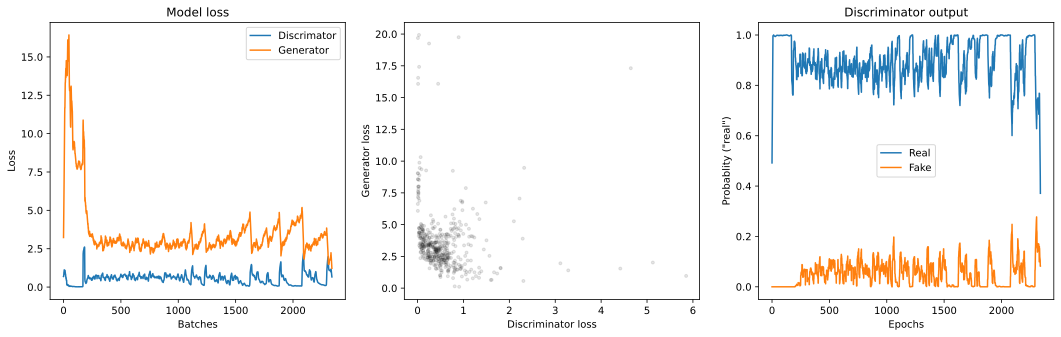

In [12]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,2300])
# ax[0].set_ylim([-.5,6])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some fake fashion!

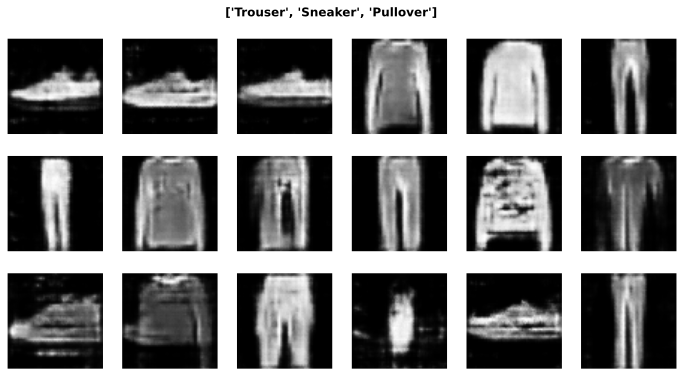

In [13]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().squeeze(),cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep,y=.95,fontweight='bold')
plt.show()

# Additional explorations

In [14]:
# 1) I've mentioned before that GANs can be quite sensitive to subtle changes in model architecture. Try running the code
#    again with exactly one change: Set the Adam 'betas' parameters to their default values (simply remove that argument
#    from the code. How much of an impact does this have on the results? More generally, these sensitivities can be 
#    frustrating when trying to build new models; the best thing to do is search the web for similar kinds of models and
#    be inspired by their decisision (but don't assume that a model is good just because it's on the web!).
# 